In [1]:
import os
import json
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import scipy.stats as stats

import statsmodels.api as sm

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

In [2]:
# product, time_reso = 'CMORPH', '3h'
product, time_reso = 'IMERG', '3h'

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy')

if product == 'SM2RAIN':
    yy_s, yy_e = 2007, 2012
    year_vector = np.arange(yy_s, yy_e+1)
else:
    yy_s, yy_e = 2002, 2012
    year_vector = np.arange(yy_s, yy_e+1)

years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : IMERG_3h.json
Number of threads: 22
Neighborhood area: 5x5



In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    DEM = gpd.read_file(os.path.join(veneto_dir,'Veneto_DEM_500.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
DATA = xr.open_dataset(os.path.join(dir_base,'Satellite','3_DOWN',f'VENETO_DOWN_{product}_3h_{yy_s}_{yy_e}_npix_5.nc'))
lon = DATA.lon.values
lat = DATA.lat.values
lon2d, lat2d = np.meshgrid(lon, lat)

N_SAT = DATA.N.values
C_SAT = DATA.C.values
W_SAT = DATA.W.values

Q_SAT = DATA.Quantile.values

TR = DATA.Tr.values

DATA


<xarray.Dataset> Size: 420kB
Dimensions:   (year: 11, lat: 25, lon: 30, Tr: 4)
Coordinates:
  * year      (year) int64 88B 2002 2003 2004 2005 2006 ... 2009 2010 2011 2012
  * Tr        (Tr) int64 32B 10 20 50 100
  * lat       (lat) float32 100B 44.55 44.65 44.75 44.85 ... 46.75 46.85 46.95
  * lon       (lon) float32 120B 10.55 10.65 10.75 10.85 ... 13.25 13.35 13.45
Data variables:
    N         (year, lat, lon) float64 66kB 137.0 140.0 150.0 ... 205.0 196.0
    C         (year, lat, lon) float64 66kB 9.659 9.632 8.894 ... 9.62 8.65
    W         (year, lat, lon) float64 66kB 0.735 0.7444 ... 0.6222 0.5838
    Nd        (year, lat, lon) float64 66kB ...
    Cd        (year, lat, lon) float64 66kB ...
    Wd        (year, lat, lon) float64 66kB ...
    Quantile  (Tr, lat, lon) float64 24kB 158.1 164.4 158.5 ... 288.5 324.1
Attributes:
    description:  Yearly Weibull Paramaters Downscale using IMERG for Veneto ...

In [7]:
# DATA = xr.open_dataset(os.path.join(dir_base,'Weibull',f'VENETO_WEIBULL_OBS_{product}_1981_2023.nc'))
# DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

DATA = xr.open_dataset(os.path.join(dir_base,'Weibull',f'VENETO_WEIBULL_OBS_{product}_{yy_s}_{yy_e}.nc'))

N_OBS = DATA.Wetdays.values
C_OBS = DATA.Scale.values
W_OBS = DATA.Shape.values

Q_OBS = DATA.Quantile.values

DATA

<xarray.Dataset> Size: 222kB
Dimensions:   (time: 11, lat: 25, lon: 30, RT: 4)
Coordinates:
  * time      (time) datetime64[ns] 88B 2002-01-01 2003-01-01 ... 2012-01-01
  * RT        (RT) int64 32B 10 20 50 100
  * lat       (lat) float32 100B 44.55 44.65 44.75 44.85 ... 46.75 46.85 46.95
  * lon       (lon) float32 120B 10.55 10.65 10.75 10.85 ... 13.25 13.35 13.45
Data variables:
    Wetdays   (time, lat, lon) float64 66kB nan nan nan nan ... nan nan nan nan
    Scale     (time, lat, lon) float64 66kB nan nan nan nan ... nan nan nan nan
    Shape     (time, lat, lon) float64 66kB nan nan nan nan ... nan nan nan nan
    Quantile  (RT, lat, lon) float64 24kB nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Weibull parameters for Veneto rain gauges using IMERG 0.1x0...

In [8]:
mask = ~np.isnan(C_OBS) & ~np.isnan(C_SAT)

In [9]:
C_OBS_clean = np.where(mask, C_OBS, np.nan)
C_SAT_clean = np.where(mask, C_SAT, np.nan)

Text(0.0, 1.0, '(b) Scale SAT')

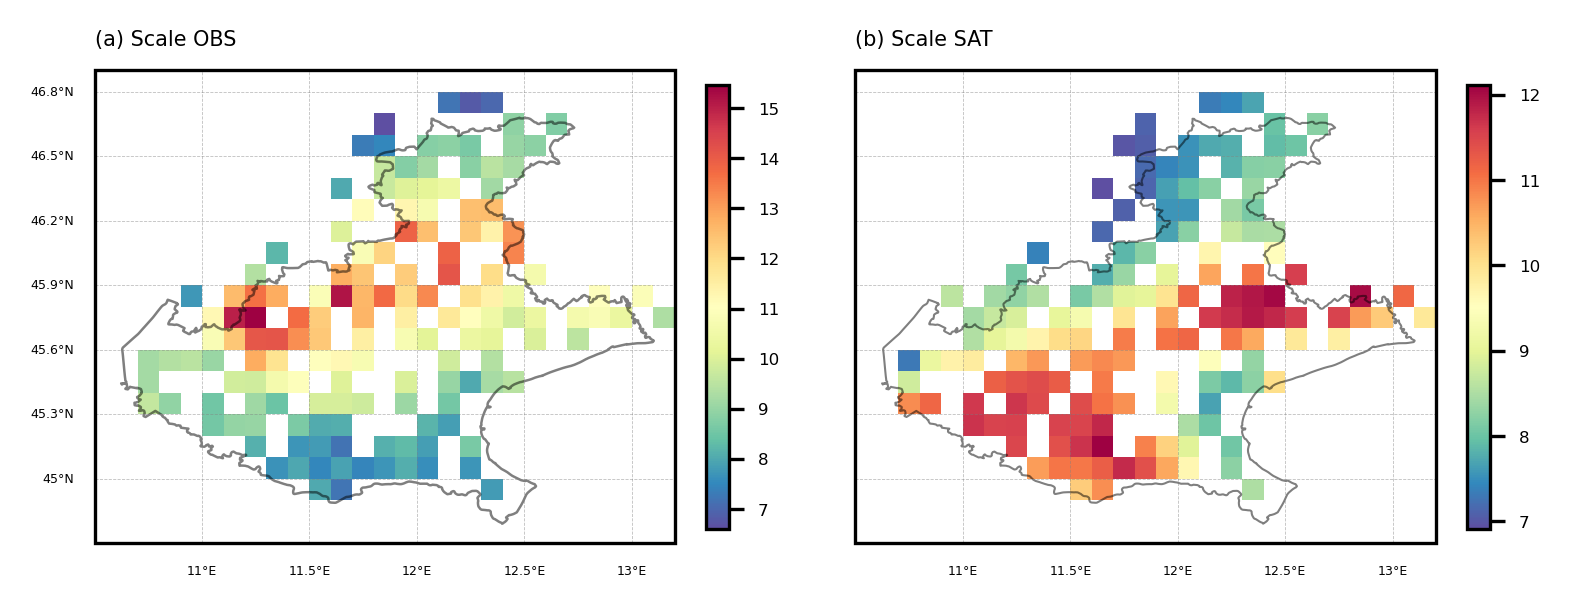

In [10]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(VENETO.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.6, alpha=0.5)

a1 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C_OBS_clean,axis=0), cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a1, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Scale OBS', loc='left', fontsize=5)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([10.5, 13.2, 44.7, 46.9], crs=proj)
ax1.add_geometries(VENETO.geometry, ccrs.PlateCarree(), edgecolor='k', facecolor='None', linewidth=0.5, alpha=0.5)

a2 = ax1.pcolormesh(lon2d, lat2d, np.nanmean(C_SAT_clean,axis=0), cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

cbar = plt.colorbar(a2, ax=ax1, fraction=0.035)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Scale SAT', loc='left', fontsize=5)


In [11]:
N_OBS_list = N_OBS[mask]
N_SAT_list = N_SAT[mask]

C_OBS_list = C_OBS[mask]
C_SAT_list = C_SAT[mask]

W_OBS_list = W_OBS[mask]
W_SAT_list = W_SAT[mask]

Text(0.0, 1.0, '(c) Shape')

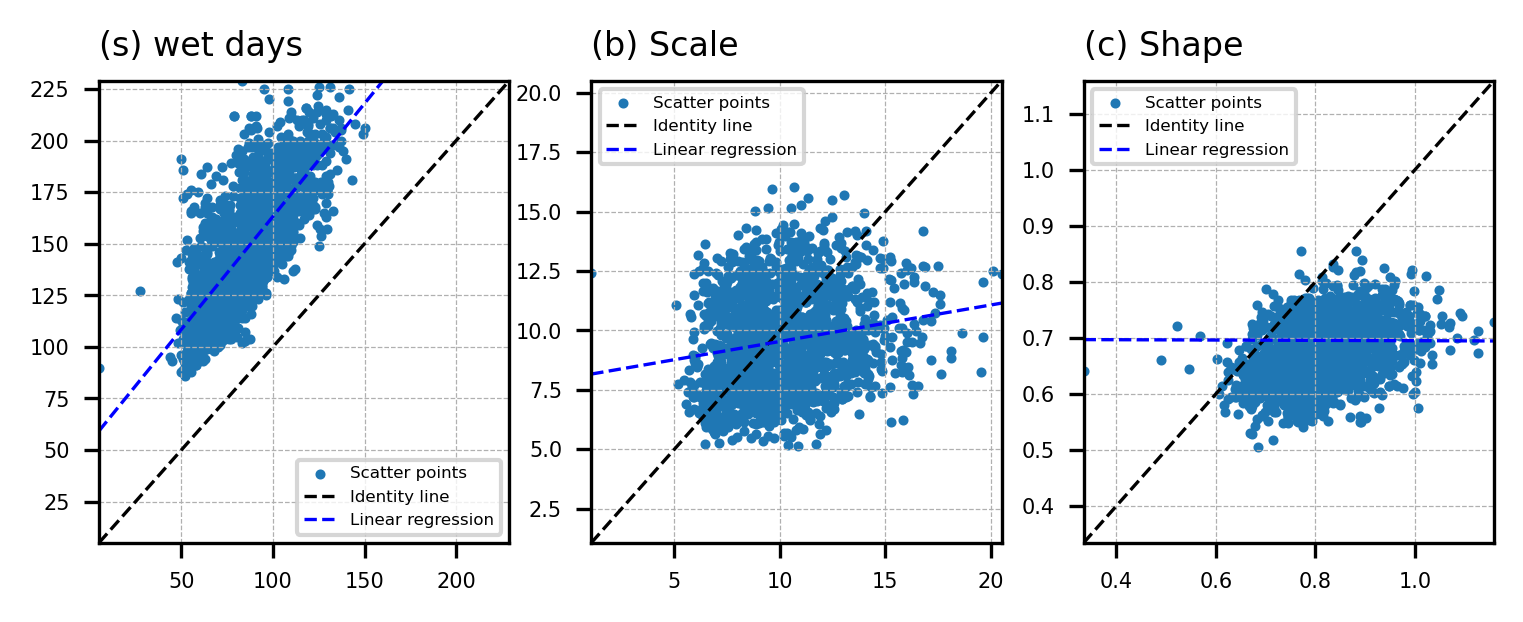

In [12]:
fig = plt.figure(figsize=(6,2),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
max_val = np.max([
                np.nanmax(N_OBS_list),
                np.nanmax(N_SAT_list)])
min_val = np.min([
                np.nanmin(N_OBS_list),
                np.nanmin(N_SAT_list)])

xx = np.arange(min_val,max_val+1,1)

ax1.scatter(N_OBS_list, N_SAT_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(N_OBS_list, N_SAT_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(s) wet days', fontsize=8, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
max_val = np.max([
                np.nanmax(C_OBS_list),
                np.nanmax(C_SAT_list)])
min_val = np.min([
                np.nanmin(C_OBS_list),
                np.nanmin(C_SAT_list)])

xx = np.arange(min_val,max_val+1,1)

ax1.scatter(C_OBS_list, C_SAT_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(C_OBS_list, C_SAT_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(b) Scale', fontsize=8, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
max_val = np.max([
                np.nanmax(W_OBS_list),
                np.nanmax(W_SAT_list)])
min_val = np.min([
                np.nanmin(W_OBS_list),
                np.nanmin(W_SAT_list)])

xx = np.arange(min_val,max_val+1,1)

ax1.scatter(W_OBS_list, W_SAT_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(C_OBS_list, W_SAT_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(c) Shape', fontsize=8, loc='left')

In [13]:
def CDFt(obs, sat, sat_future=None):
    """
    Aplica la corrección de sesgo usando CDFt.
    Si se proporciona 'sat_future', también ajusta datos futuros.
    """
    # CDF empírica de los datos observados y satelitales
    obs_sorted = np.sort(obs)
    sat_sorted = np.sort(sat)
    
    # Transformación de cuantiles
    sat_percentiles = stats.rankdata(sat, method='average') / len(sat)
    corrected_sat = np.interp(sat_percentiles, np.linspace(0,1,len(obs_sorted)), obs_sorted)
    
    if sat_future is not None:
        sat_future_percentiles = stats.rankdata(sat_future, method='average') / len(sat_future)
        corrected_sat_future = np.interp(sat_future_percentiles, np.linspace(0,1,len(obs_sorted)), obs_sorted)
        return corrected_sat, corrected_sat_future
    
    return corrected_sat

def ISIMIP_QM(obs, sat):
    """
    Aplica la corrección de sesgo usando ISIMIP QM (Quantile Mapping).
    """
    # Cuantiles de los datos
    quantiles = np.linspace(0, 1, len(obs))
    
    # Ajuste de cuantiles
    obs_quantiles = np.quantile(obs, quantiles)
    sat_quantiles = np.quantile(sat, quantiles)
    
    # Aplicar ajuste a los datos satelitales
    corrected_sat = np.interp(sat, sat_quantiles, obs_quantiles)
    
    return corrected_sat

def loess_bias_correction(obs, sat, frac=0.3):
    """
    Aplica la corrección de sesgo usando LOESS (LOWESS).
    
    Parámetros:
    obs  -> Serie observada (C_OBS_clean)
    sat  -> Serie satelital (C_SAT_clean)
    frac -> Fracción de datos usados en la regresión local (0.2 a 0.5 es recomendado)
    
    Retorna:
    - Serie corregida
    """
    # Aplicar LOWESS (Locally Weighted Scatterplot Smoothing)
    loess_fit = sm.nonparametric.lowess(obs, sat, frac=frac, return_sorted=False)
    
    return loess_fit

In [14]:
N_SAT_corrected_CDFt = CDFt(N_OBS_list, N_SAT_list)
N_SAT_corrected_ISIMIP = ISIMIP_QM(N_OBS_list, N_SAT_list)
N_SAT_corrected_LOESS = loess_bias_correction(N_OBS_list, N_SAT_list, frac=0.3)

In [15]:
C_SAT_corrected_CDFt = CDFt(C_OBS_list, C_SAT_list)
C_SAT_corrected_ISIMIP = ISIMIP_QM(C_OBS_list, C_SAT_list)
C_SAT_corrected_LOESS = loess_bias_correction(C_OBS_list, C_SAT_list, frac=0.3)

In [16]:
W_SAT_corrected_CDFt = CDFt(W_OBS_list, W_SAT_list)
W_SAT_corrected_ISIMIP = ISIMIP_QM(W_OBS_list, W_SAT_list)
W_SAT_corrected_LOESS = loess_bias_correction(W_OBS_list, W_SAT_list, frac=0.3)

In [17]:
model = LinearRegression()

model.fit(N_SAT_list.reshape(-1, 1), N_OBS_list)
N_SAT_linear = model.predict(N_SAT_list.reshape(-1, 1))

model.fit(C_SAT_list.reshape(-1, 1), C_OBS_list)
C_SAT_linear = model.predict(C_SAT_list.reshape(-1, 1))

model.fit(W_SAT_list.reshape(-1, 1), W_OBS_list)
W_SAT_linear = model.predict(W_SAT_list.reshape(-1, 1))

In [18]:
C_ref, _ = spearmanr(C_OBS_list, C_SAT_list)
C_CDF, _ = spearmanr(C_OBS_list, C_SAT_corrected_CDFt)
C_ISI, _ = spearmanr(C_OBS_list, C_SAT_corrected_ISIMIP)
C_LIN, _ = spearmanr(C_OBS_list, C_SAT_linear)
C_LOE, _ = spearmanr(C_OBS_list, C_SAT_corrected_LOESS)

N_ref, _ = spearmanr(N_OBS_list, N_SAT_list)
N_CDF, _ = spearmanr(N_OBS_list, N_SAT_corrected_CDFt)
N_ISI, _ = spearmanr(N_OBS_list, N_SAT_corrected_ISIMIP)
N_LIN, _ = spearmanr(N_OBS_list, N_SAT_linear)
N_LOE, _ = spearmanr(N_OBS_list, N_SAT_corrected_LOESS)

W_ref, _ = spearmanr(W_OBS_list, W_SAT_list)
W_CDF, _ = spearmanr(W_OBS_list, W_SAT_corrected_CDFt)
W_ISI, _ = spearmanr(W_OBS_list, W_SAT_corrected_ISIMIP)
W_LIN, _ = spearmanr(W_OBS_list, W_SAT_linear)
W_LOE, _ = spearmanr(W_OBS_list, W_SAT_corrected_LOESS)

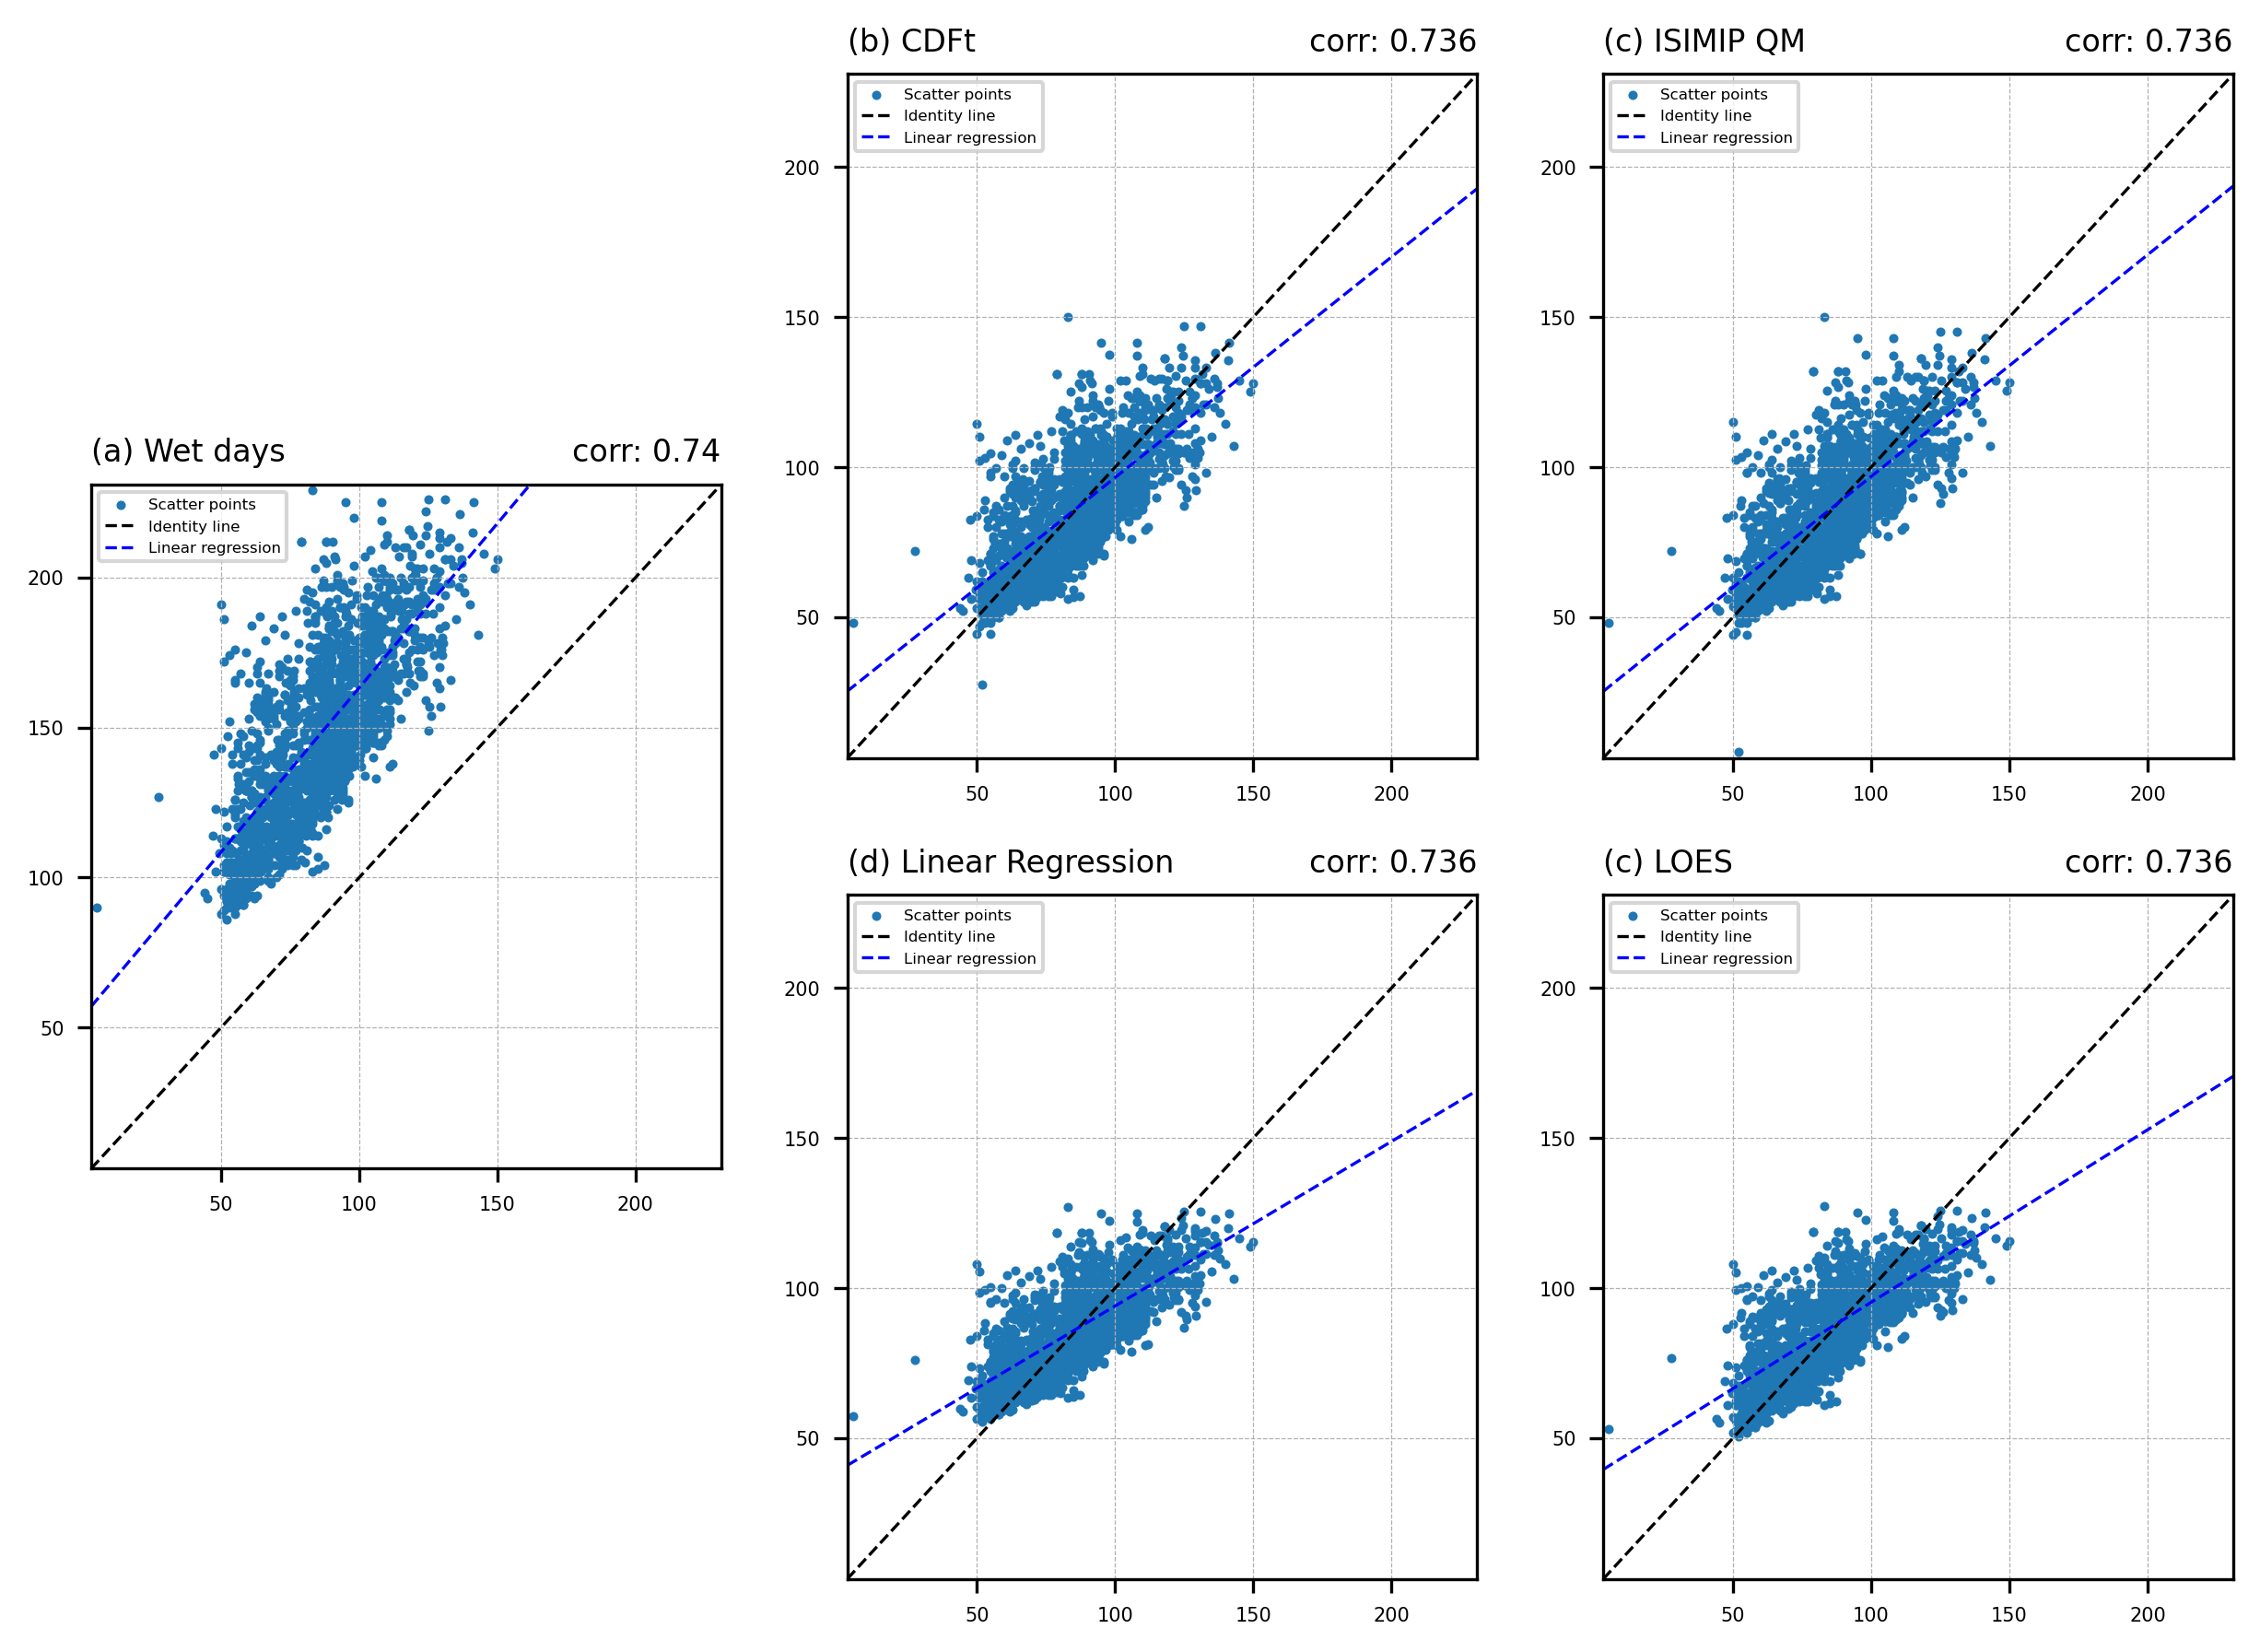

In [19]:
fig = plt.figure(figsize=(10,9),dpi=300)
gs = gridspec.GridSpec(5,3)

max_val = np.max([
                np.nanmax(N_OBS_list),
                np.nanmax(N_SAT_list),
                np.nanmax(N_SAT_corrected_CDFt),
                np.nanmax(N_SAT_corrected_ISIMIP),
                np.nanmax(N_SAT_linear)])+2
min_val = np.min([
                np.nanmin(N_OBS_list),
                np.nanmin(N_SAT_list),
                np.nanmin(N_SAT_corrected_CDFt),
                np.nanmin(N_SAT_corrected_ISIMIP),
                np.nanmin(N_SAT_linear)])-2

# ==============================================================================
ax1 = plt.subplot(gs[1:3, 0])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(N_OBS_list, N_SAT_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(N_OBS_list, N_SAT_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(a) Wet days', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(N_ref,2)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0:2, 1])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(N_OBS_list, N_SAT_corrected_CDFt, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(N_OBS_list, N_SAT_corrected_CDFt)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(b) CDFt', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(N_CDF,3)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0:2, 2])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(N_OBS_list, N_SAT_corrected_ISIMIP, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(N_OBS_list, N_SAT_corrected_ISIMIP)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(c) ISIMIP QM', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(N_ISI,3)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[2:4, 1])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(N_OBS_list, N_SAT_linear, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(N_OBS_list, N_SAT_linear)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(d) Linear Regression', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(N_LIN,3)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[2:4, 2])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(N_OBS_list, N_SAT_corrected_LOESS, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(N_OBS_list, N_SAT_corrected_LOESS)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(c) LOES', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(N_LOE,3)}', fontsize=8, loc='right')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.5, wspace=0.2)


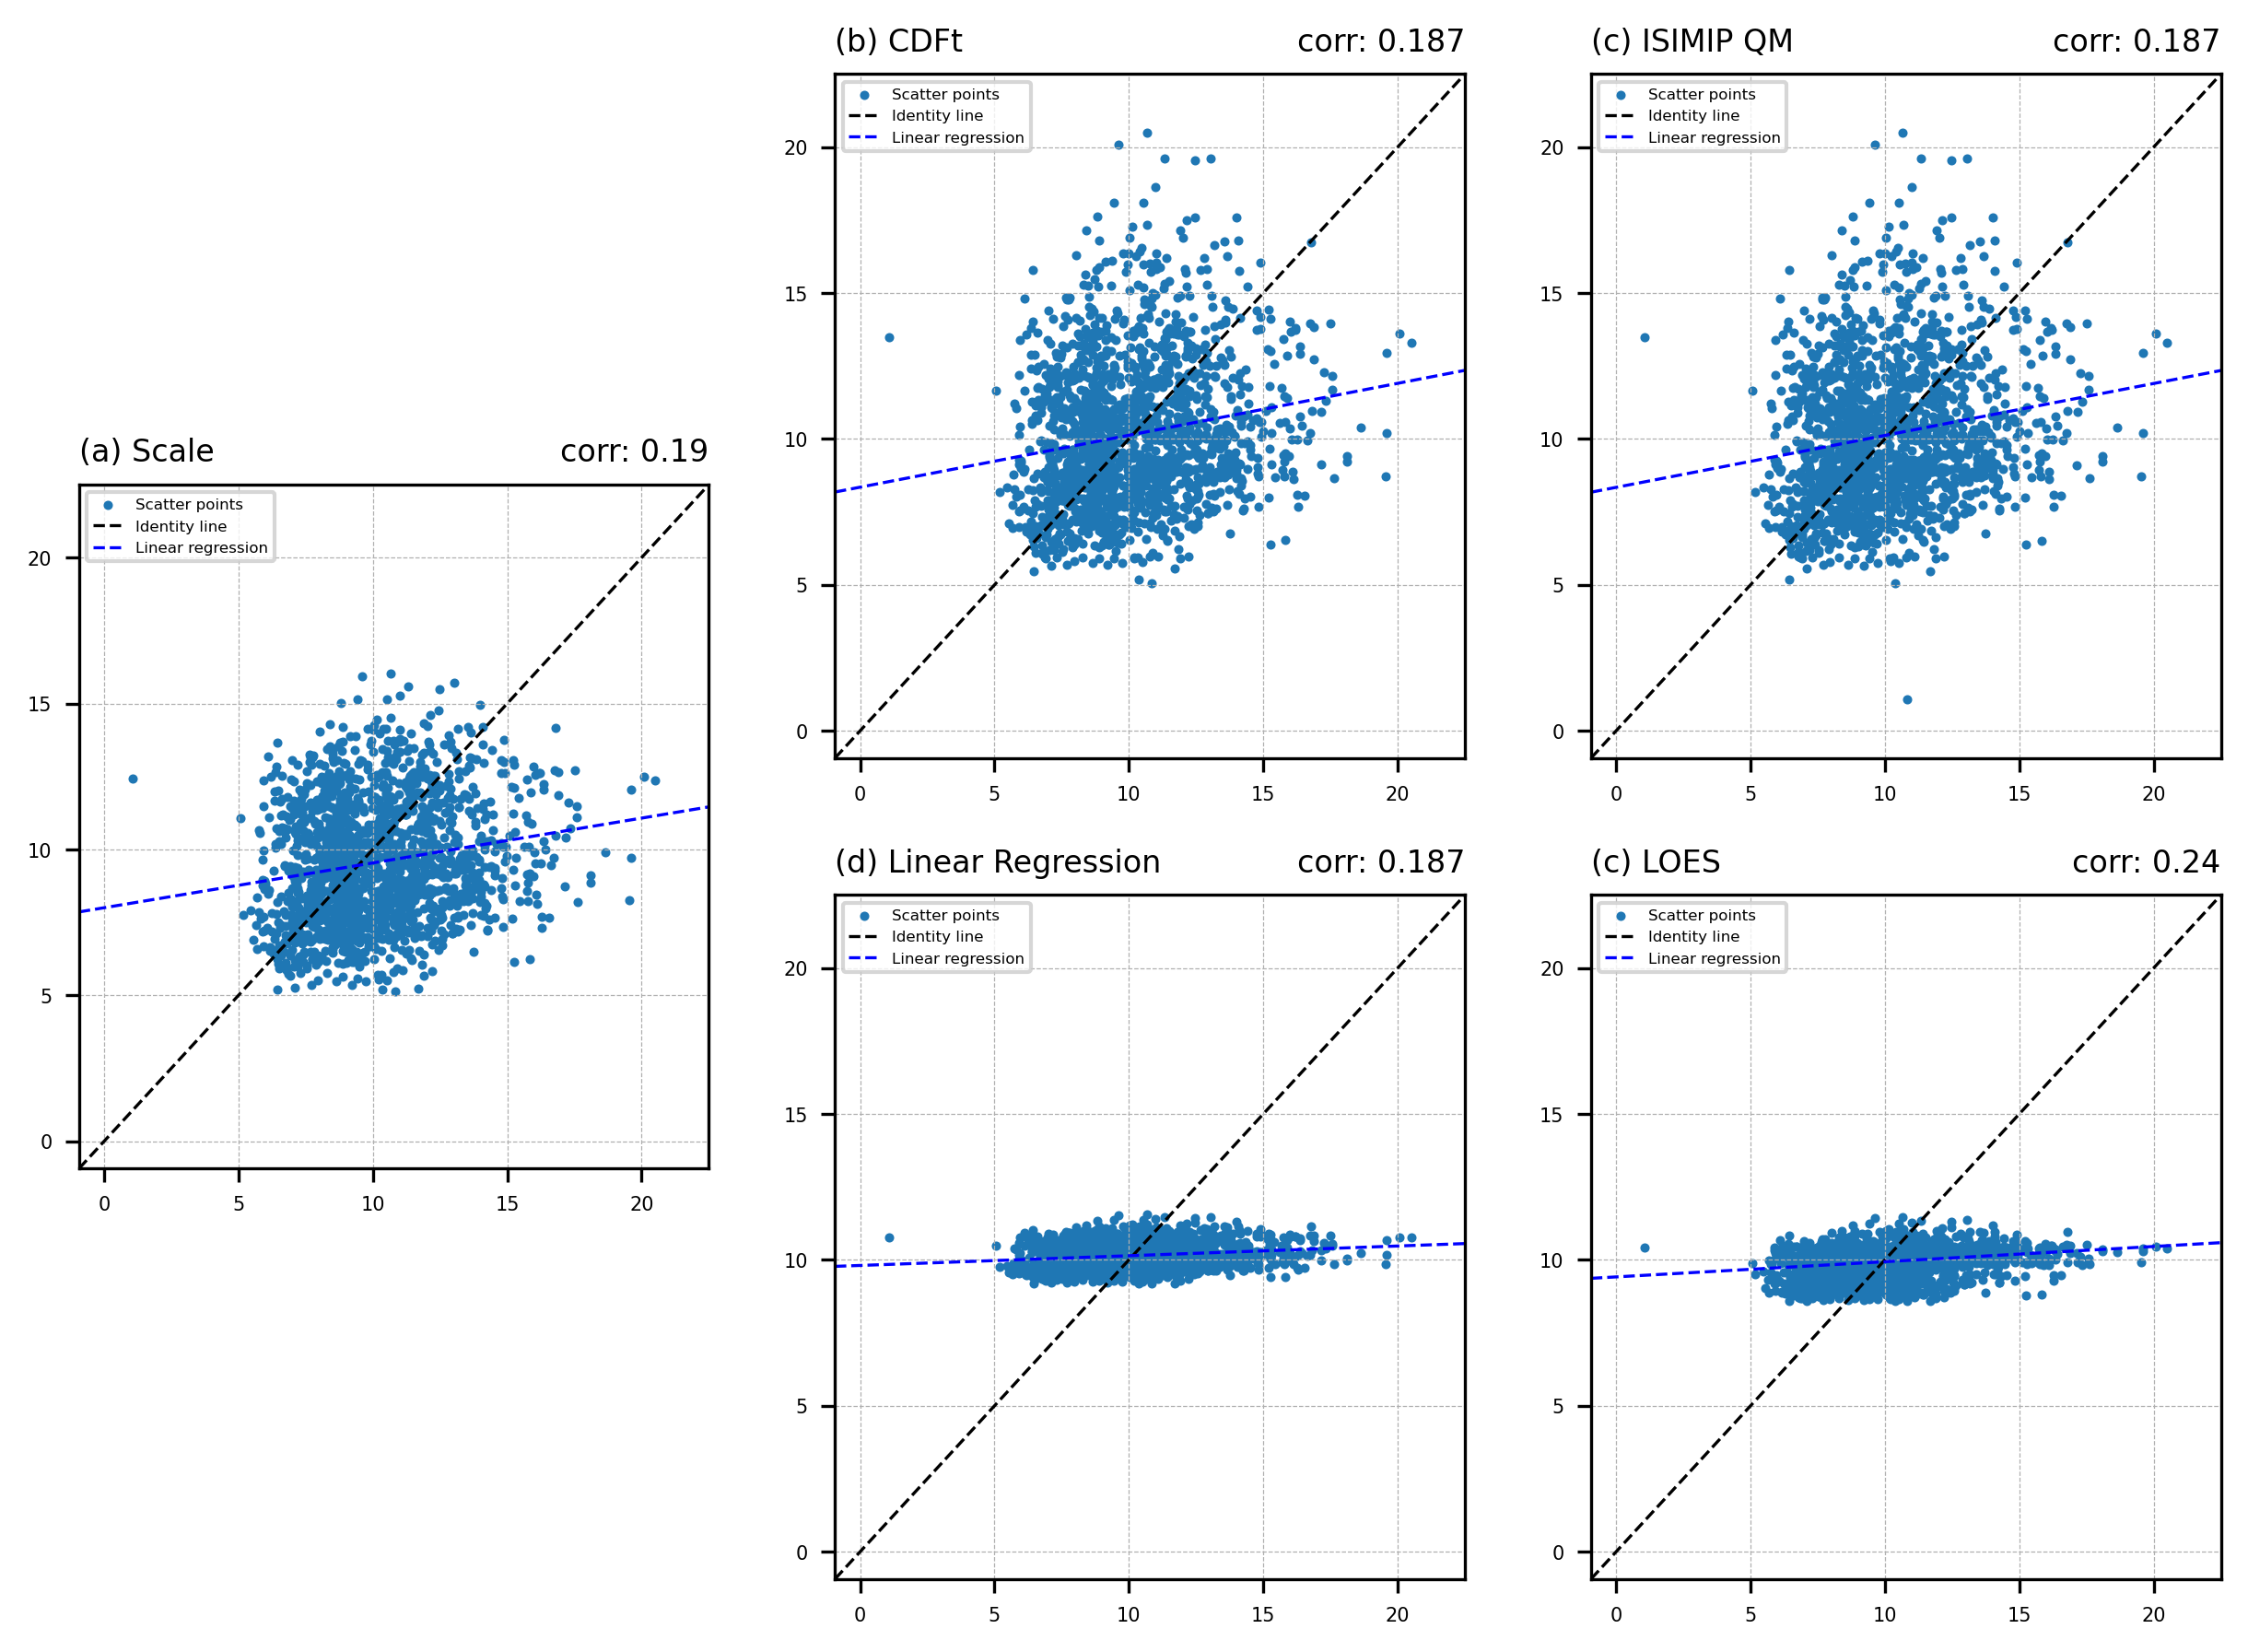

In [20]:
fig = plt.figure(figsize=(10,9),dpi=300)
gs = gridspec.GridSpec(5,3)

max_val = np.max([
                np.nanmax(C_OBS_list),
                np.nanmax(C_SAT_list),
                np.nanmax(C_SAT_corrected_CDFt),
                np.nanmax(C_SAT_corrected_ISIMIP),
                np.nanmax(C_SAT_linear)])+2
min_val = np.min([
                np.nanmin(C_OBS_list),
                np.nanmin(C_SAT_list),
                np.nanmin(C_SAT_corrected_CDFt),
                np.nanmin(C_SAT_corrected_ISIMIP),
                np.nanmin(C_SAT_linear)])-2

# ==============================================================================
ax1 = plt.subplot(gs[1:3, 0])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(C_OBS_list, C_SAT_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(C_OBS_list, C_SAT_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(a) Scale', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(C_ref,2)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0:2, 1])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(C_OBS_list, C_SAT_corrected_CDFt, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(C_OBS_list, C_SAT_corrected_CDFt)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(b) CDFt', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(C_CDF,3)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0:2, 2])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(C_OBS_list, C_SAT_corrected_ISIMIP, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(C_OBS_list, C_SAT_corrected_ISIMIP)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(c) ISIMIP QM', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(C_ISI,3)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[2:4, 1])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(C_OBS_list, C_SAT_linear, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(C_OBS_list, C_SAT_linear)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(d) Linear Regression', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(C_LIN,3)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[2:4, 2])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(C_OBS_list, C_SAT_corrected_LOESS, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(C_OBS_list, C_SAT_corrected_LOESS)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(c) LOES', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(C_LOE,3)}', fontsize=8, loc='right')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.5, wspace=0.2)


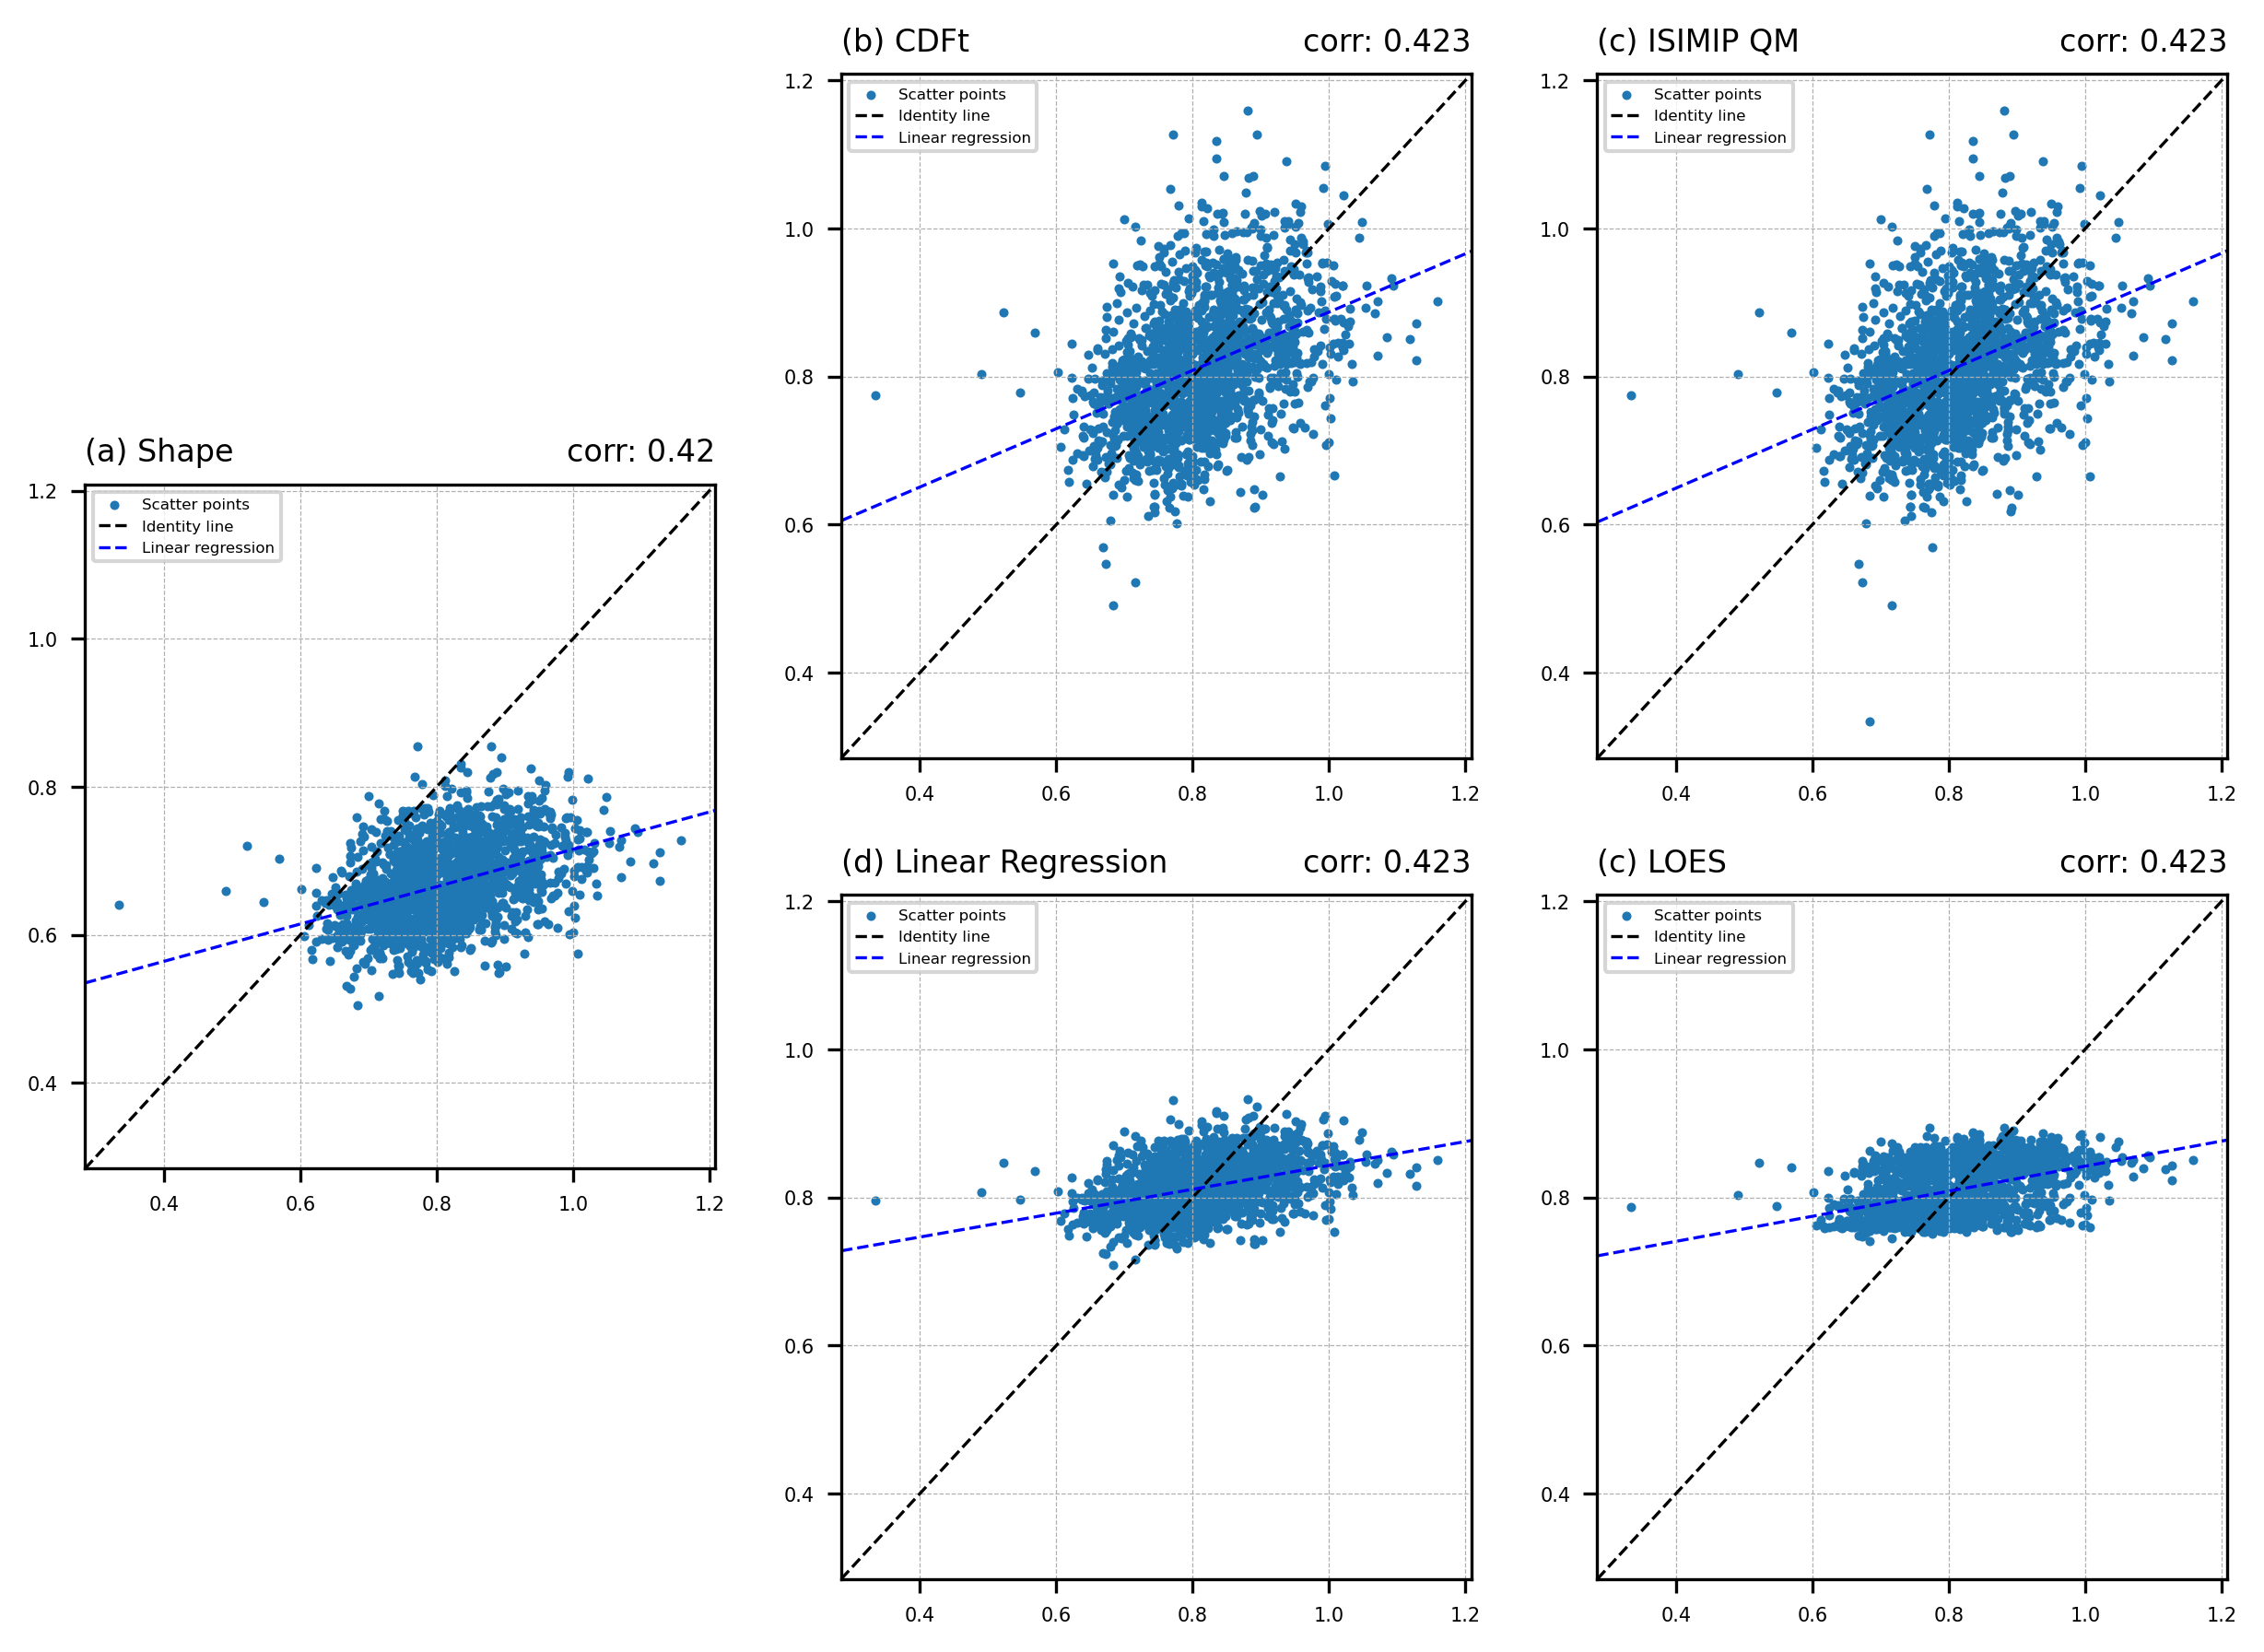

In [21]:
fig = plt.figure(figsize=(10,9),dpi=300)
gs = gridspec.GridSpec(5,3)

max_val = np.max([
                np.nanmax(W_OBS_list),
                np.nanmax(W_SAT_list),
                np.nanmax(W_SAT_corrected_CDFt),
                np.nanmax(W_SAT_corrected_ISIMIP),
                np.nanmax(W_SAT_linear)])+0.05
min_val = np.min([
                np.nanmin(W_OBS_list),
                np.nanmin(W_SAT_list),
                np.nanmin(W_SAT_corrected_CDFt),
                np.nanmin(W_SAT_corrected_ISIMIP),
                np.nanmin(W_SAT_linear)])-0.05

# ==============================================================================
ax1 = plt.subplot(gs[1:3, 0])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(W_OBS_list, W_SAT_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(W_OBS_list, W_SAT_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(a) Shape', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(W_ref,2)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0:2, 1])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(W_OBS_list, W_SAT_corrected_CDFt, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(W_OBS_list, W_SAT_corrected_CDFt)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(b) CDFt', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(W_CDF,3)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0:2, 2])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(W_OBS_list, W_SAT_corrected_ISIMIP, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(W_OBS_list, W_SAT_corrected_ISIMIP)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(c) ISIMIP QM', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(W_ISI,3)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[2:4, 1])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(W_OBS_list, W_SAT_linear, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(W_OBS_list, W_SAT_linear)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(d) Linear Regression', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(W_LIN,3)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[2:4, 2])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(W_OBS_list, W_SAT_corrected_LOESS, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(W_OBS_list, W_SAT_corrected_LOESS)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_title('(c) LOES', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(W_LOE,3)}', fontsize=8, loc='right')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.5, wspace=0.2)


In [22]:
N_SAT_2 = np.where(mask, N_SAT, np.nan)
C_SAT_2 = np.where(mask, C_SAT, np.nan)
W_SAT_2 = np.where(mask, W_SAT, np.nan)

In [23]:
N_SAT_CDFt = np.where(mask, N_SAT, np.nan)
C_SAT_CDFt = np.where(mask, C_SAT, np.nan)
W_SAT_CDFt = np.where(mask, W_SAT, np.nan)
for i in range(len(lat)):
    for j in range(len(lon)):
        if np.count_nonzero(np.isnan(N_SAT_CDFt[:,0,0])==True) == years_num:
            continue
        else:
            N_SAT_CDFt[:,i,j] = CDFt(N_OBS[:i,j], N_SAT[:,i,j])
            C_SAT_CDFt[:,i,j] = CDFt(C_OBS[:i,j], C_SAT[:,i,j])
            W_SAT_CDFt[:,i,j] = CDFt(W_OBS[:i,j], W_SAT[:,i,j])

Text(0.0, 1.0, '(f) Shape CDFt')

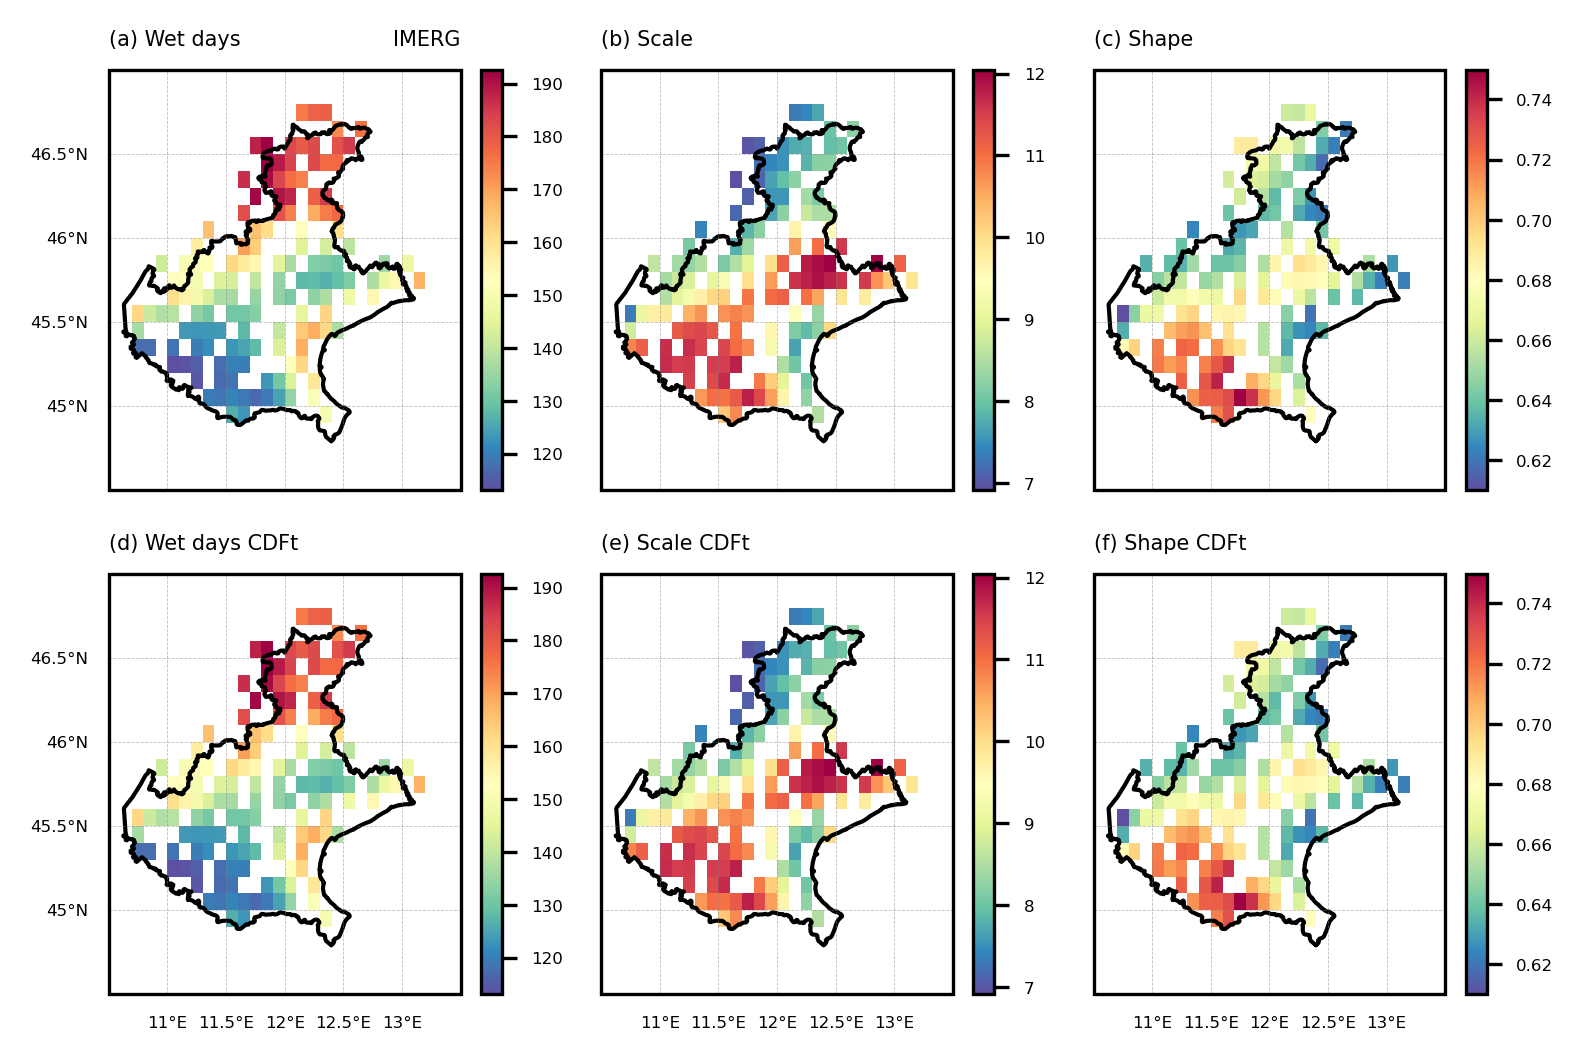

In [24]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(N_SAT_2,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Wet days', fontsize=5, loc='left')
ax1.set_title(product, fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(C_SAT_2,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Scale', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(W_SAT_2,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Shape', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(N_SAT_CDFt,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(d) Wet days CDFt', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(C_SAT_CDFt,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(e) Scale CDFt', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, np.mean(W_SAT_CDFt,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(f) Shape CDFt', fontsize=5, loc='left')


In [36]:
Q_OBS[2,:,:][Q_OBS[2,:,:]==np.nanmax(Q_OBS[2,:,:])] = np.nan

In [37]:
Tr = [10, 20, 50, 100]
Q_NEW = ART_down.pre_quantiles_array(N_SAT_CDFt, C_SAT_CDFt, W_SAT_CDFt, Tr, lat, lon, 1)

In [38]:
mask_Q = ~np.isnan(Q_OBS)
Q_SAT_clean = np.where(mask_Q, Q_SAT, np.nan)

Text(0.0, 1.0, '(c) CDFt SAT Quantiles')

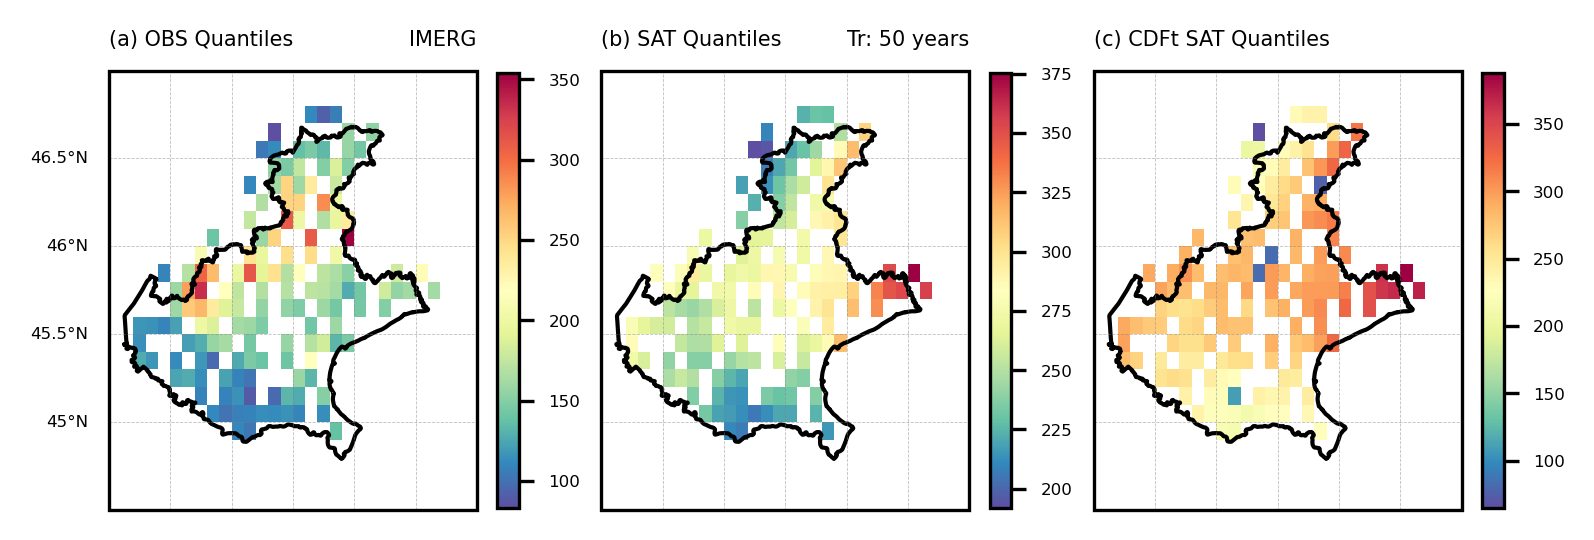

In [39]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, Q_OBS[2,:,:], cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) OBS Quantiles', fontsize=5, loc='left')
ax1.set_title(product, fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, Q_SAT_clean[2,:,:], cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) SAT Quantiles', fontsize=5, loc='left')
ax1.set_title(f'Tr: {Tr[2]} years', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.pcolormesh(lon2d, lat2d, Q_NEW[2,:,:], cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) CDFt SAT Quantiles', fontsize=5, loc='left')

In [40]:
mask_list = ~np.isnan(Q_OBS[2,:,:])

Q_OBS_list = Q_OBS[2,:,:][mask_list]
Q_SAT_list = Q_SAT[2,:,:][mask_list]
Q_NEW_list = Q_NEW[2,:,:][mask_list]

In [41]:
ERROR1 = (Q_SAT_list-Q_OBS_list)/Q_OBS_list
ERROR2 = (Q_NEW_list-Q_OBS_list)/Q_OBS_list

Text(1.0, 1.0, '2002 to 2012')

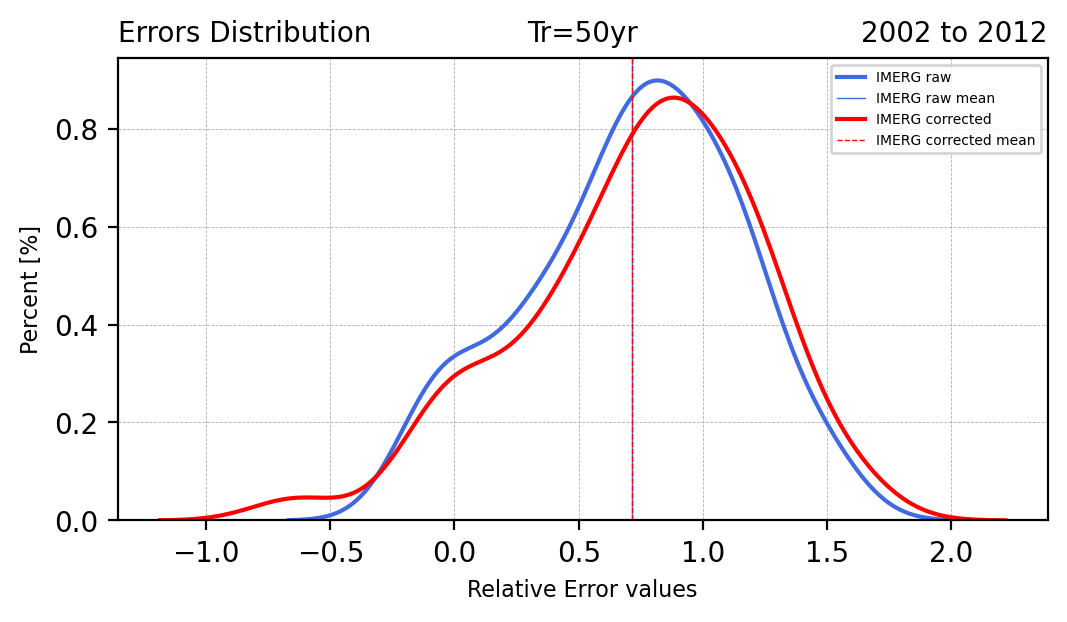

In [42]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple']

fig = plt.figure(figsize=(6,3),dpi=200)
gs = gridspec.GridSpec(1,1)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(ERROR1, color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'{product} raw')
ax1.axvline(np.nanmean(ERROR1), color=colors[0], linestyle='-', linewidth=0.5, label=f'{product} raw mean')

sns.kdeplot(ERROR2,color=colors[1],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'{product} corrected')
ax1.axvline(np.nanmean(ERROR1), color=colors[1], linestyle='--', linewidth=0.5, label=f'{product} corrected mean')

ax1.set_ylabel('Percent [%]',fontsize=8)
ax1.set_xlabel('Relative Error values',fontsize=8)
ax1.legend(fontsize=5, loc=1, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_title('Errors Distribution', fontsize=10, loc='left')
ax1.set_title(f'Tr={Tr[2]}yr',fontsize=10, loc='Center')
ax1.set_title(f'{yy_s} to {yy_e}',fontsize=10, loc='right')


Text(1.0, 1.0, 'corr: 0.42')

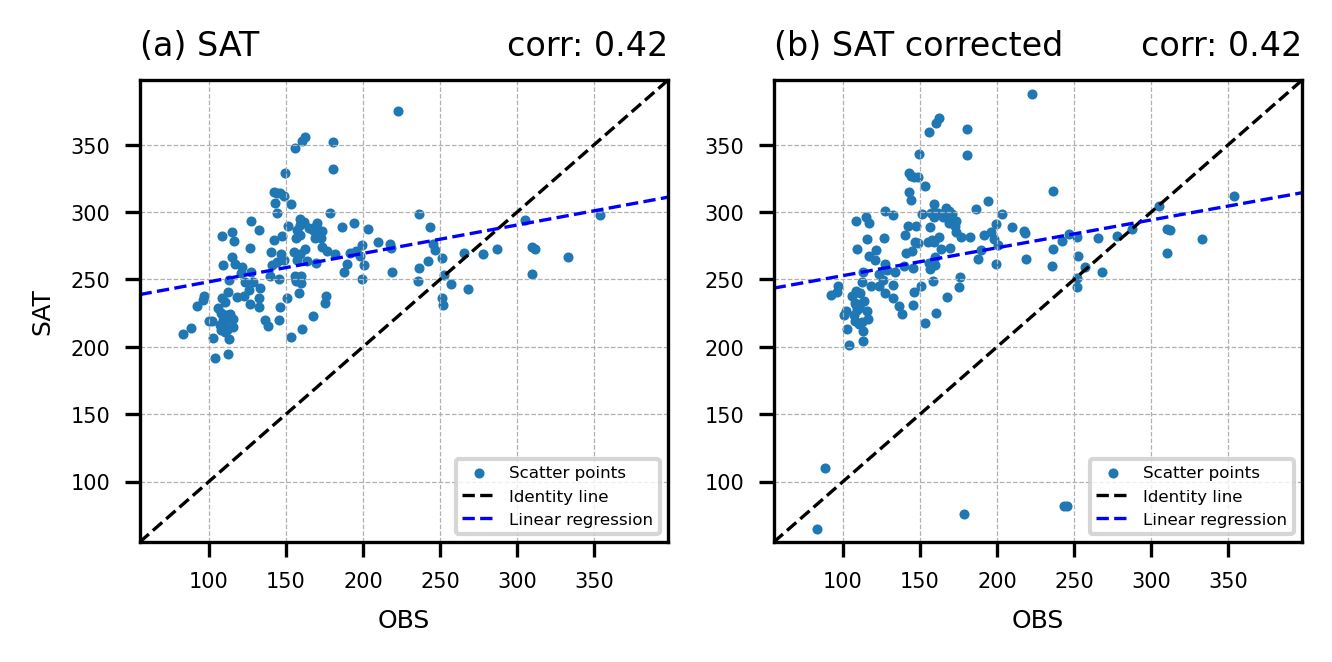

In [52]:
fig = plt.figure(figsize=(5,2),dpi=300)
gs = gridspec.GridSpec(1,2)

max_val = np.max([
                np.nanmax(Q_OBS_list),
                np.nanmax(Q_SAT_list),
                np.nanmax(Q_NEW_list)])+10
min_val = np.min([
                np.nanmin(Q_OBS_list),
                np.nanmin(Q_SAT_list),
                np.nanmin(Q_NEW_list)])-10

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(Q_OBS_list, Q_SAT_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(Q_OBS_list, Q_SAT_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_xlabel('OBS', fontsize=6)
ax1.set_ylabel('SAT', fontsize=6)

ax1.set_title(f'(a) SAT', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(W_ref,2)}', fontsize=8, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
xx = np.arange(min_val,max_val+1,1)

ax1.scatter(Q_OBS_list, Q_NEW_list, s=2, label='Scatter points')
ax1.plot(xx,xx,color='k',linewidth=0.8,linestyle='--', label='Identity line')
slope, intercept, _, _, _ = stats.linregress(Q_OBS_list, Q_NEW_list)
y_pred = slope * xx + intercept
ax1.plot(xx,y_pred,color='b',linewidth=0.8,linestyle='--', label='Linear regression')

ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_ylim(min_val,max_val)
ax1.set_xlim(min_val,max_val)
ax1.legend(fontsize=4)

ax1.set_xlabel('OBS', fontsize=6)

ax1.set_title('(b) SAT corrected', fontsize=8, loc='left')
ax1.set_title(f'corr: {np.round(W_ref,2)}', fontsize=8, loc='right')